In [ ]:
# ==========================================
# TORCH
# ==========================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

# ==========================================
# NUMPY / PANDAS / MATPLOTLIB / SEABORN
# ==========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# SCIKIT-LEARN
# ==========================================
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, roc_auc_score, matthews_corrcoef,
    cohen_kappa_score, roc_curve, auc
)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier

# ==========================================
# RASTERIO / GDAL
# ==========================================
import rasterio as rio

# ==========================================
# SISTEMA / UTILIDADES
# ==========================================
import gc
from tqdm import tqdm


Las siguientes líneas de código definen rutas absolutas hacia archivos raster que se usarán como insumos para análisis geoespacial o modelado. Cada variable almacena como cadena la ubicación completa de un archivo TIFF específico: `respuesta` apunta a la capa de deslizamientos (variable objetivo), mientras que `raster1` a `raster10` contienen distintas capas predictoras como pendiente, distancia a deslizamientos, distancia a ríos, curvatura, TWI, elevación, distancia a carreteras, cobertura del suelo, litología y precipitación promedio. Esto permite cargarlas posteriormente para procesamiento y extracción de valores en el modelado.


In [3]:
respuesta = r"D:/Edgar/01. Articulo regresión logistica/Insumos/Variables/Modelo Ordinal/Muestras/Landslides.tif"
raster1 = r"D:/Edgar/01. Articulo regresión logistica/Insumos/Variables/Modelo Ordinal/Muestras/Slope.tif"
raster2 = r"D:/Edgar/01. Articulo regresión logistica/Insumos/Variables/Modelo Ordinal/Muestras/DisFalls.tif"
raster3 = r"D:/Edgar/01. Articulo regresión logistica/Insumos/Variables/Modelo Ordinal/Muestras/DisRivers.tif"
raster4 = r"D:/Edgar/01. Articulo regresión logistica/Insumos/Variables/Modelo Ordinal/Muestras/Curvature.tif"
raster5 = r"D:/Edgar/01. Articulo regresión logistica/Insumos/Variables/Modelo Ordinal/Muestras/TWI.tif"
raster6 = r"D:/Edgar/01. Articulo regresión logistica/Insumos/Variables/Modelo Ordinal/Muestras/Elevation.tif"
raster7 = r"D:/Edgar/01. Articulo regresión logistica/Insumos/Variables/Modelo Ordinal/Muestras/DisRoads.tif"
raster8 = r"D:/Edgar/01. Articulo regresión logistica/Insumos/Variables/Modelo Ordinal/Muestras/CLCORD.tif"
raster9 = r"D:/Edgar/01. Articulo regresión logistica/Insumos/Variables/Modelo Ordinal/Muestras/LitologyORD.tif"
raster10 = r"D:/Edgar/01. Articulo regresión logistica/Insumos/Variables/Modelo Ordinal/Muestras/PreProMen.tif"

Las siguientes líneas de código cargan rutas de carpetas y sufijos, inicializan un DataFrame, leen archivos TIFF como arrays y los convierten en tensores, filtran valores inválidos, calculan frecuencias de valores únicos, almacenan los datos en un DataFrame, calculan la razón de frecuencias entre muestras y datos completos, agregan máximos y mínimos por variable, calculan diferencias y un índice `PR`, y finalmente ordenan las variables por este índice de forma descendente.

In [5]:
rutas = [r"D:/Edgar/01. Articulo regresión logistica/Insumos/Variables/Modelo Ordinal/completas", r"D:/Edgar/01. Articulo regresión logistica/Insumos/Variables/Modelo Ordinal/muestras"]

add = ["Com", "Mue"]

dfCom = pd.DataFrame()
for x, path in enumerate(rutas):
    ruta = path
    archivostif = ["Elevation.tif","LitologyORD.tif", "Slope.tif","DisRivers.tif","DisRoads.tif","CLCORD.tif","DisFalls.tif","Curvature.tif","TWI.tif","PreProMen.tif"]

    ImagenesCompletas = []
    TensoresCompletos = []
    
    for archivo in archivostif:
        with rio.open(ruta+"/"+str(archivo)) as src:
            raster = src.read(1)
            ImagenesCompletas.append(raster)

    for imagen in ImagenesCompletas:
        tensor = torch.tensor(imagen.astype(np.int16))
        TensoresCompletos.append(tensor)
    del ImagenesCompletas

    data = []

    for i, tensor in enumerate(TensoresCompletos):
    # Filtrar los valores -128 y 15
        filtered_tensor = tensor[(tensor != -128) & (tensor != 15)]
    
        unique_values, counts = torch.unique(filtered_tensor, return_counts=True)
        total_count = filtered_tensor.size(0)
        frequencies = counts.float() / total_count
   
        for value, count, freq in zip(unique_values, counts, frequencies):
            data.append([archivostif[i], value.item(), count.item(), freq.item() * 100])
            
            df = pd.DataFrame(data, columns=['Tensor'+ add[x], 'Valor'+ add[x], 'Cuenta'+ add[x], 'Frecuencia'+ add[x]])
    dfCom = pd.concat([dfCom, df], axis = 1)
    del TensoresCompletos

dfCom["RadioFrecuencia"] = dfCom.FrecuenciaMue/dfCom.FrecuenciaCom
DfRF = dfCom.groupby("TensorCom")["RadioFrecuencia"].agg(["max","min"]).reset_index()
DfRF.columns = ["Variable", "MaxRF", "MinRF"]

DfRF["MaxRf-MinRf"] = DfRF.MaxRF - DfRF.MinRF
DfRF["(MaxRf-MinRf)*MinRF"] = DfRF["MaxRf-MinRf"]* DfRF.MinRF

DfRF["PR"] = DfRF["MaxRf-MinRf"]/DfRF["(MaxRf-MinRf)*MinRF"]
DfRF.sort_values(by="PR", ascending=False)

,Variable,MaxRF,MinRF,MaxRf-MinRf,(MaxRf-MinRf)*MinRF,PR
7,PreProMen.tif,2.367545,0.203135,2.164411,0.439667,4.922841
8,Slope.tif,2.035937,0.227649,1.808289,0.411654,4.392735
5,Elevation.tif,1.546558,0.532378,1.014180,0.539928,1.878363
6,LitologyORD.tif,13.760285,0.603163,13.157122,7.935887,1.657927
3,DisRivers.tif,1.184623,0.652106,0.532517,0.347257,1.533494
4,DisRoads.tif,1.182022,0.703639,0.478383,0.336609,1.421182
0,CLCORD.tif,16.710019,0.711651,15.998368,11.385250,1.405184
2,DisFalls.tif,1.539920,0.739206,0.800714,0.591893,1.352803
1,Curvature.tif,1.073960,0.886459,0.187501,0.166212,1.128084
9,TWI.tif,1.134335,0.944380,0.189956,0.179390,1.058896


Las siguientes líneas de código definen listas de variables y sus valores de PR, crean un gráfico de barras horizontales para visualizar la relación de cada variable con su PR, configuran etiquetas y título del gráfico, y finalmente muestran la figura utilizando Matplotlib.

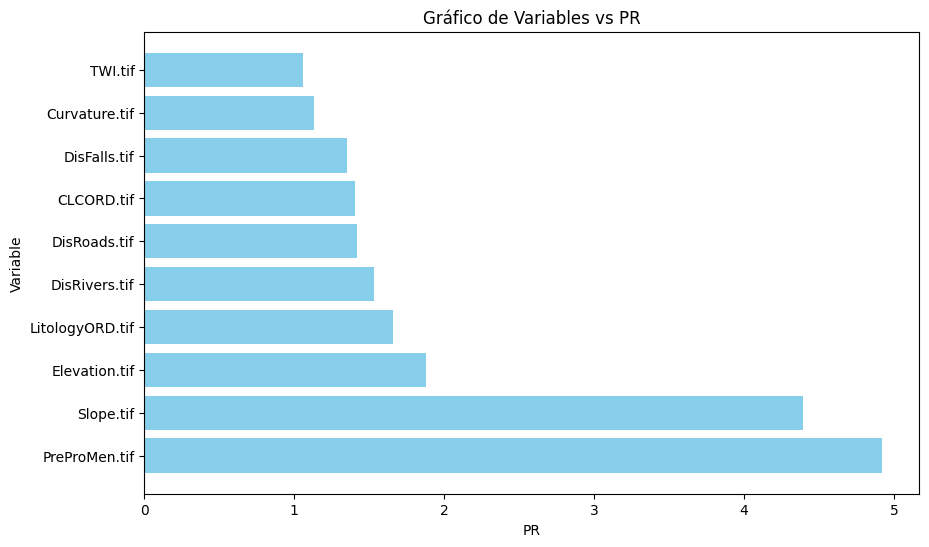

In [4]:
variables = ['PreProMen.tif', 'Slope.tif', 'Elevation.tif', 'LitologyORD.tif', 
             'DisRivers.tif', 'DisRoads.tif', 'CLCORD.tif', 'DisFalls.tif', 
             'Curvature.tif', 'TWI.tif']
pr_values = [4.922841, 4.392735, 1.878363, 1.657927, 1.533494, 1.421182, 
             1.405184, 1.352803, 1.128084, 1.058896]

# Crear gráfico de barras horizontales
plt.figure(figsize=(10, 6))
plt.barh(variables, pr_values, color='skyblue')

# Etiquetas y título
plt.xlabel('PR')
plt.ylabel('Variable')
plt.title('Gráfico de Variables vs PR')

# Mostrar el gráfico
plt.show()

Las siguientes líneas de código crean listas que agrupan las rutas absolutas de los archivos raster y sus nombres correspondientes, facilitando la referencia y carga ordenada de las capas predictoras y la variable respuesta en análisis geoespacial o modelado.

In [6]:
rutas = [ raster10,raster1,raster6,raster9,raster3,raster7,raster8,raster2,raster4, raster5,respuesta]
Nombres = ["PreProMen","Slope","Elevation","LitologyORD", "DisRiver","DisRoads","CLCORD","DisFalls","Curvature","TWI" ,"Respuesta"]

Las siguientes líneas de código leen los archivos raster desde las rutas definidas, almacenan cada capa en una lista como arreglos NumPy y luego convierten esos arreglos a tensores de PyTorch, liberando la memoria de los objetos intermedios y forzando la recolección de basura para optimizar el uso de memoria.

In [7]:
Imagenes = []
Tensores = []

for ruta in rutas:
    with rio.open(ruta) as src:
        raster = src.read(1)
        Imagenes.append(raster)

for imagen in Imagenes:
    tensor = torch.tensor(imagen)
    Tensores.append(tensor)

del Imagenes
del raster
gc.collect()


652

Las siguientes líneas de código recorren cada tensor de la lista original y aplican un filtrado de valores. Si el tensor contiene el valor 15, se elimina; si contiene -128, también se elimina; de lo contrario, se filtran los valores menores a 3. Los tensores resultantes se almacenan en una nueva lista y se libera la memoria de los tensores originales para mantener un manejo eficiente de recursos.

In [8]:
Tensores_Filtro = []

for tensor in Tensores:
    if (tensor ==15).any():
        Tensores_Filtro.append(tensor[tensor != 15])
    elif (tensor == -128).any():
        Tensores_Filtro.append(tensor[tensor != -128])
    else:
        Tensores_Filtro.append(tensor[tensor < 3])

del Tensores
gc.collect()

0

Las siguientes líneas de código ajustan todos los tensores filtrados a un tamaño uniforme, truncando cada tensor a la longitud mínima definida (`min_size`). Esto asegura que todos los tensores tengan la misma dimensión para procesamiento posterior. Luego se libera la memoria de la lista original y se fuerza la recolección de basura para optimizar el uso de recursos.


In [9]:
Tensores2 = []
min_size = 2191774
for tensor in Tensores_Filtro:
    Tensores2.append(tensor[:min_size])
    
del Tensores_Filtro
gc.collect()

0

Las siguientes líneas de código normalizan los primeros diez tensores escalando sus valores entre 0 y 1 usando la fórmula `(x - min) / (max - min)`, mientras que el último tensor (la variable respuesta) se añade sin normalizar. Esto prepara los datos para modelado, asegurando que las variables predictoras estén en la misma escala, y luego libera memoria de los tensores originales y fuerza la recolección de basura.


In [10]:
Tensores_Normalizados = []
for tensor in Tensores2[:10]:
    Tensores_Normalizados.append((tensor.float() - tensor.min().item()) / (tensor.max().item() - tensor.min().item()))
Tensores_Normalizados.append(Tensores2[-1])

del Tensores2
gc.collect()


0

Las siguientes líneas de código ajustan los valores del último tensor (la variable respuesta) para codificarlo como binario, asignando 1 a deslizamientos y 0 a no deslizamientos, y luego imprimen la cantidad de píxeles correspondientes a cada clase. Esto permite conocer la distribución de clases antes de entrenar un modelo.


In [11]:
Tensores_Normalizados[-1][Tensores_Normalizados[-1]==1] = 1
Tensores_Normalizados[-1][Tensores_Normalizados[-1]==2] = 0

print("el numero de pixeles de deslizamiento es: ",len(Tensores_Normalizados[-1][Tensores_Normalizados[-1]==1]))
print("el numero de pixeles de No deslizamiento es: ", len(Tensores_Normalizados[-1][Tensores_Normalizados[-1]==0]))

el numero de pixeles de deslizamiento es:  1076117
el numero de pixeles de No deslizamiento es:  1115657


Las siguientes líneas de código apilan los tensores normalizados de las variables predictoras en una sola estructura, convierten los tensores a arreglos NumPy y preparan las matrices de características `X` y etiquetas `y`. Luego, se realiza una división estratificada en conjuntos de entrenamiento y prueba usando un 15 % de los datos para test, y se liberan variables temporales para optimizar la memoria.


In [12]:
stacked = torch.stack(Tensores_Normalizados[:-1], dim=1)

X = stacked.numpy()  # shape: [n_samples, n_features]
y = Tensores_Normalizados[-1].numpy().astype(int)  

X_train_MT, X_test_MT, y_train_MT, y_test_MT = train_test_split(
    X, y, test_size=0.15, random_state=1234, stratify=y
) 

del X, y
gc.collect()

0

In [13]:
def calculate_statistics(y_test, y_pred, y_pred_proba):
    accuracy = accuracy_score(y_test, y_pred)
    print(f"✅ Precisión en test: {accuracy*100:.2f}%")

    auc = roc_auc_score(y_test, y_pred_proba)
    print(f"✅ Area bajo la curva ROC (AUC): {auc:.4f}")

    mcc = matthews_corrcoef(y_test, y_pred)
    print(f"✅ Coeficiente de correlación de Matthews (MCC): {mcc:.4f}")

    kappa = cohen_kappa_score(y_test, y_pred)
    print(f"✅ Cohen’s Kappa: {kappa:.4f}")

### regresion Logistica LR

Las siguientes líneas de código definen un modelo de regresión logística usando regularización L2 (`penalty='l2'`), con fuerza de regularización inversa `C=1.0`, y el solucionador `lbfgs`, configurado para un máximo de 1000 iteraciones. Luego, el modelo se entrena con los datos de entrenamiento `X_train_MT` y `y_train_MT`. Tras el entrenamiento, se generan predicciones discretas `y_pred` sobre el conjunto de prueba `X_test_MT` y se calculan las probabilidades de pertenencia a la clase positiva `y_pred_proba_LR`. La función `calculate_statistics` se utiliza para evaluar métricas de desempeño como precisión, AUC u otras estadísticas definidas. Finalmente, se libera memoria eliminando `y_pred` y ejecutando el recolector de basura con `gc.collect()`.



In [14]:
modelLR = LogisticRegression(
    penalty='l2',       # regularización L2
    C=1.0,              # inverso de la fuerza de regularización
    solver='lbfgs',     # optimizador
    max_iter=1000
)

modelLR.fit(X_train_MT, y_train_MT)

y_pred = modelLR.predict(X_test_MT)
y_pred_proba_LR = modelLR.predict_proba(X_test_MT)[:, 1]

calculate_statistics(y_test_MT,y_pred, y_pred_proba_LR)

del  y_pred
gc.collect()

✅ Precisión en test: 85.70%
✅ Area bajo la curva ROC (AUC): 0.9325
✅ Coeficiente de correlación de Matthews (MCC): 0.7152
✅ Cohen’s Kappa: 0.7141


26

### Maquinas de soporte vectorial

Las siguientes líneas de código crean un clasificador tipo SVM lineal usando `SGDClassifier` con la función de pérdida `modified_huber`, que combina ventajas de SVM y regresión logística. Se aplica regularización L2 (`penalty='l2'`) con un parámetro `alpha=1e-4` que controla la fuerza de regularización, y se ajustan los pesos de las clases automáticamente (`class_weight='balanced'`) para manejar desequilibrios. El aprendizaje se realiza con tasa adaptativa (`learning_rate='optimal'`) durante un máximo de 1000 iteraciones con tolerancia `tol=1e-3` y semilla `random_state=1234`. Luego, se instancia `ModelSVM1` como copia y se entrena con los datos `X_train_MT` y `y_train_MT`. Se generan predicciones `y_pred` y probabilidades de la clase positiva `y_pred_proba_SVM` sobre el conjunto de prueba, y se evalúan métricas con `calculate_statistics`. Finalmente, se libera memoria eliminando `y_pred` y llamando a `gc.collect()`.


In [81]:
ModelSVM = SGDClassifier(
    loss='modified_huber',              # equivalente a un SVM lineal
    penalty='l2',              # regularización estándar
    alpha=1e-4,                # inverso del C de SVM (regularización)
    class_weight='balanced',   # ajusta pesos según frecuencia de clases
    learning_rate='optimal',   # ajusta el paso automáticamente
    max_iter=1000,
    tol=1e-3,
    random_state=1234
)

ModelSVM1 = ModelSVM
ModelSVM1.fit(X_train_MT, y_train_MT)

y_pred = ModelSVM1.predict(X_test_MT)
y_pred_proba_SVM = ModelSVM1.predict_proba(X_test_MT)[:, 1]

calculate_statistics(y_test_MT,y_pred, y_pred_proba_SVM)

del y_pred
gc.collect()

✅ Precisión en test: 85.82%
✅ Area bajo la curva ROC (AUC): 0.9316
✅ Coeficiente de correlación de Matthews (MCC): 0.7201
✅ Cohen’s Kappa: 0.7168


0

### RandomForest

Las siguientes líneas de código crean un clasificador de bosque aleatorio (`RandomForestClassifier`) con 100 árboles (`n_estimators=100`) y profundidad máxima de 10 (`max_depth=10`) para equilibrar complejidad y sobreajuste. Se configuran parámetros para controlar la división de nodos (`min_samples_split=8`, `min_samples_leaf=4`) y se selecciona un subconjunto de características por árbol (`max_features='sqrt'`) para diversidad. Se ajustan los pesos de clases (`class_weight='balanced'`) para compensar desbalances, se activa el muestreo con reemplazo (`bootstrap=True`) y se usan todos los núcleos del CPU (`n_jobs=-1`) con semilla fija (`random_state=1234`) para reproducibilidad. Luego, se instancia `Modelrf`, se entrena con `X_train_MT` y `y_train_MT`, se generan predicciones `y_pred` y probabilidades `y_pred_proba_RF` sobre el conjunto de prueba, se evalúan métricas con `calculate_statistics`, y finalmente se libera memoria eliminando `y_pred` y llamando a `gc.collect()`.

In [82]:
ModelRF = RandomForestClassifier(
    n_estimators=100,          # número de árboles → mejora estabilidad
    max_depth=10,            # sin límite → el bosque lo ajusta solo
    min_samples_split=8,       # evita sobreajuste leve
    min_samples_leaf=4,        # tamaño mínimo de hoja
    max_features='sqrt',       # usa raíz cuadrada del nº de variables por árbol
    class_weight='balanced',   # corrige desbalance entre clases
    bootstrap=True,            # usa muestreo con reemplazo 
    n_jobs=-1,                 # usa todos los núcleos del CPU
    random_state=1234          # reproducibilidad
)

Modelrf = ModelRF
Modelrf.fit(X_train_MT, y_train_MT)

y_pred = Modelrf.predict(X_test_MT)
y_pred_proba_RF = Modelrf.predict_proba(X_test_MT)[:, 1]

calculate_statistics(y_test_MT,y_pred, y_pred_proba_RF)

del  y_pred
gc.collect()


✅ Precisión en test: 90.21%
✅ Area bajo la curva ROC (AUC): 0.9682
✅ Coeficiente de correlación de Matthews (MCC): 0.8088
✅ Cohen’s Kappa: 0.8045


69

### Red Neuronal Convolucional


Las siguientes líneas de código preparan los datos para un modelo de red neuronal convolucional (CNN). Se convierte el tensor `stacked` a tipo `float` como `X_cnn` y se obtiene `y_cnn` a partir del último tensor normalizado, asegurando que contenga valores enteros 0/1. Se crea un `TensorDataset` combinando `X_cnn` con una dimensión extra y `y_cnn`. Luego se divide el dataset en entrenamiento (50%) y prueba (50%) usando `random_split` con semilla fija para reproducibilidad. Se crean `DataLoader` para entrenamiento y prueba con tamaños de lote grandes y mezcla aleatoria (`shuffle=True`). Finalmente, se extraen los tensores de entrenamiento y prueba (`train_X`, `train_y`, `test_X`, `test_y_CNN`) y se liberan variables intermedias y memoria con `gc.collect()`.


In [83]:
X_cnn = stacked.float()  # [N, 10]
y_cnn = Tensores_Normalizados[-1].long().squeeze()               # [N] enteros 0/1

dataset = TensorDataset(X_cnn.unsqueeze(1), y_cnn)  # [N, 1, 10]

train_size = int(0.5 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, 
                                           [train_size, test_size], 
                                           generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_dataset, batch_size=90000, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=30000, shuffle=True)

train_X, train_y = train_dataset[:]
test_X, test_y_CNN = test_dataset[:]


del X_cnn, y_cnn, stacked, Tensores_Normalizados 
gc.collect()



0

Las siguientes líneas de código definen la arquitectura de una red neuronal convolucional 1D (`ModelCNN`) usando `nn.Sequential`. La red comienza con una capa convolucional que transforma un canal de entrada en 15 mapas de características con un kernel de tamaño 3, seguida de normalización por lotes y activación `Tanh`. Luego aplica un `MaxPool1d` para reducir dimensionalidad y un `Dropout` del 10% para regularización. Se aplana la salida y se conecta a una capa totalmente conectada de 15 neuronas, normalizada y activada con `Tanh` con otro `Dropout`. Finalmente, la red termina con una capa lineal de 2 neuronas para producir la salida binaria correspondiente a las clases de deslizamiento y no deslizamiento.


In [28]:
ModelCNN = nn.Sequential(
    nn.Conv1d(in_channels=1, out_channels=15, kernel_size=3),
    nn.BatchNorm1d(15),          # 🔹 Normaliza después de la convolución
    nn.Tanh(),
    nn.MaxPool1d(kernel_size=2),
    nn.Dropout(0.1),            # 🔹 Regulariza después del pooling
    nn.Flatten(),
    nn.Linear(15 * 4, 15),       # (10 - 3 + 1 = 8) → MaxPool(2) → 4
    nn.BatchNorm1d(15),          # 🔹 Normaliza capa densa
    nn.Tanh(),
    nn.Dropout(0.1),            # 🔹 Regulariza después de activación
    nn.Linear(15, 2)             # 🔹 Salida binaria (2 clases)
)

Las siguientes líneas de código implementan el entrenamiento de la red convolucional definida (`ModelCNN`). Se establece `CrossEntropyLoss` como función de pérdida para clasificación binaria y se usa el optimizador `Adagrad` con tasa de aprendizaje de 0.01. El entrenamiento se realiza durante 100 épocas, iterando sobre lotes de datos del `train_loader`, calculando la pérdida, retropropagando y actualizando los pesos. Cada 5 épocas, el modelo se evalúa sobre el `test_loader` para calcular la pérdida de validación y la precisión (`Val Acc`). Finalmente, se imprime la pérdida de entrenamiento promedio, la pérdida de validación y la precisión de validación para monitorear el desempeño del modelo.


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(ModelCNN.parameters(), lr=0.01)

num_epochs = 100
for epoch in range(num_epochs):
    ModelCNN.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = ModelCNN(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    
    # Validación
    if (epoch+1) % 5 == 0:
        ModelCNN.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for X_val, y_val in test_loader:
                outputs_val = ModelCNN(X_val)
                loss_val = criterion(outputs_val, y_val)
                val_loss += loss_val.item()
                predicted = torch.argmax(outputs_val, dim=1)
                total += y_val.size(0)
                correct += (predicted == y_val).sum().item()
        val_acc = correct / total

    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Val Loss: {val_loss/len(test_loader):.4f}, Val Acc: {val_acc*100:.2f}%")
        
        


Esta línea de código, comentada con `#`, sirve para **guardar los pesos entrenados de la red neuronal `ModelCNN`** en un archivo llamado `"ModelCNN_weights.pth"`. Al usar `state_dict()`, se almacena únicamente la información de los parámetros (pesos y sesgos) del modelo, no la arquitectura completa. Esto permite luego **recargar los pesos en el mismo modelo** usando `load_state_dict` sin necesidad de volver a entrenarlo. Básicamente, es una forma de persistir el entrenamiento para usarlo más tarde o en otro entorno.


In [ ]:
#torch.save(ModelCNN.state_dict(), "ModelCNN_weights.pth")

Las siguientes líneas de código realizan la evaluación final del modelo convolucional `ModelCNN`. Se pone el modelo en modo evaluación (`eval()`) y se desactiva el cálculo de gradientes con `torch.no_grad()`. Se obtienen todos los datos de prueba, se generan las predicciones (`outputs`), se calcula la probabilidad de la clase positiva usando `softmax` y se determina la clase predicha con `argmax`. Finalmente, los tensores se convierten a `numpy` y se calculan métricas de desempeño sobre los datos de prueba usando `calculate_statistics`.


In [30]:
ModelCNN.eval()

with torch.no_grad():
    X_test, y_test = test_dataset[:]                   # obtiene todos los datos de test
    outputs = ModelCNN(X_test)                         # [N, 2]
    y_pred_proba_CNN = torch.softmax(outputs, dim=1)[:, 1] # prob clase positiva
    y_pred = torch.argmax(outputs, dim=1)              # clase predicha

# === Convertir a numpy ===
y_true = y_test.numpy()
y_pred = y_pred.numpy()
y_pred_proba = y_pred_proba_CNN.numpy()
# === Métricas ===
calculate_statistics(y_test,y_pred, y_pred_proba_CNN)

✅ Precisión en test: 88.24%
✅ Area bajo la curva ROC (AUC): 0.9547
✅ Coeficiente de correlación de Matthews (MCC): 0.7669
✅ Cohen’s Kappa: 0.7651


## Modelos Compuestos

En este punto se inicia con la integración de modelos a pártir de las caractersiticas exctraidas del modelo CNN. Las siguientes líneas de código definen la arquitectura de la red convolucional `ModelCNN` y luego cargan pesos previamente entrenados desde el archivo `"ModelCNN_weights.pth"`. Se incluye una capa convolucional, normalización por lotes, activación `Tanh`, pooling, regularización con `Dropout` y capas densas, terminando en una salida de dos clases. Finalmente, se pone el modelo en modo evaluación (`eval()`) para que pueda usarse para predicciones sin actualizar los pesos.


In [2]:
ModelCNN = nn.Sequential(
    nn.Conv1d(in_channels=1, out_channels=15, kernel_size=3),
    nn.BatchNorm1d(15),          # 🔹 Normaliza después de la convolución
    nn.Tanh(),
    nn.MaxPool1d(kernel_size=2),
    nn.Dropout(0.1),            # 🔹 Regulariza después del pooling
    nn.Flatten(),
    nn.Linear(15 * 4, 15),       # (10 - 3 + 1 = 8) → MaxPool(2) → 4
    nn.BatchNorm1d(15),          # 🔹 Normaliza capa densa
    nn.Tanh(),
    nn.Dropout(0.1),            # 🔹 Regulariza después de activación
    nn.Linear(15, 2)             # 🔹 Salida binaria (2 clases)
)
ModelCNN.load_state_dict(torch.load("ModelCNN_weights.pth"))
ModelCNN.eval()

Sequential(
  (0): Conv1d(1, 15, kernel_size=(3,), stride=(1,))
  (1): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Tanh()
  (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Dropout(p=0.1, inplace=False)
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=60, out_features=15, bias=True)
  (7): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Tanh()
  (9): Dropout(p=0.1, inplace=False)
  (10): Linear(in_features=15, out_features=2, bias=True)
)

Las siguientes líneas de código crean un extractor de características a partir de las primeras nueve capas de `ModelCNN`, que incluyen convolución, normalización, activación, pooling y flattening. Luego, extrae las características de los datos de entrenamiento y prueba sin actualizar los pesos (`torch.no_grad()`), generando representaciones de 15 dimensiones por muestra, y libera la memoria de los datasets originales para optimizar el uso de RAM.


In [85]:
feature_extractor = nn.Sequential(*list(ModelCNN.children())[:9])

train_X, train_y = train_dataset[:]
test_X, test_y = test_dataset[:]

with torch.no_grad():
    train_features = feature_extractor(train_X)  # [N_train, 15]
    test_features = feature_extractor(test_X)    # [N_test, 15]
    

del test_dataset, train_dataset
gc.collect()

489

### CNN-LR

Las siguientes líneas de código entrenan un modelo de regresión logística utilizando las características extraídas previamente del `ModelCNN`. Primero se convierten los tensores de entrenamiento y prueba a `numpy`, luego se ajusta el clasificador a los datos de entrenamiento. Después se realizan predicciones de clase y probabilidades sobre los datos de prueba, y finalmente se calculan métricas de rendimiento usando `calculate_statistics` para evaluar la precisión y la capacidad predictiva del modelo CNN + LR.


In [86]:
classifierCNNLR = LogisticRegression(
    penalty='l2',       # regularización L2
    C=1.0,              # inverso de la fuerza de regularización
    solver='lbfgs',     # optimizador
    max_iter=1000
)

train_features_np = train_features.numpy()
train_y_np = train_y.numpy()
test_features_np = test_features.numpy()
test_y_np = test_y.numpy()

classifierCNNLR.fit(train_features_np, train_y_np)

y_pred = classifierCNNLR.predict(test_features_np)
y_probability = classifierCNNLR.predict_proba(test_features_np)
y_probability_CNNLR = [x[1] for x in y_probability]
y_true = classifierCNNLR.predict(test_features_np)

calculate_statistics(test_y_np, y_pred, y_probability_CNNLR)

✅ Precisión en test: 88.32%
✅ Area bajo la curva ROC (AUC): 0.9555
✅ Coeficiente de correlación de Matthews (MCC): 0.7674
✅ Cohen’s Kappa: 0.7665


### CNN-SVM

Las siguientes líneas de código entrenan un clasificador tipo SVM lineal (`SGDClassifier` con `modified_huber`) usando las características extraídas por el modelo CNN. Primero se ajusta el modelo a los datos de entrenamiento transformados a `numpy`. Luego se realizan predicciones de clase y de probabilidades sobre los datos de prueba, y se calculan métricas de desempeño con `calculate_statistics` para evaluar la precisión y capacidad de discriminación del modelo CNN + SVM. Finalmente, se liberan variables intermedias y se llama a `gc.collect()` para optimizar la memoria.


In [87]:
classifierCNNSVM = SGDClassifier(
    loss='modified_huber',              # equivalente a un SVM lineal
    penalty='l2',              # regularización estándar
    alpha=1e-4,                # inverso del C de SVM (regularización)
    class_weight='balanced',   # ajusta pesos según frecuencia de clases
    learning_rate='optimal',   # ajusta el paso automáticamente
    max_iter=1000,
    tol=1e-3,
    random_state=1234
)

classifierCNNSVM.fit(train_features_np, train_y_np)

y_pred = classifierCNNSVM.predict(test_features_np)
y_probability = classifierCNNSVM.predict_proba(test_features_np)
y_probability_CNNSVM = [x[1] for x in y_probability]
y_true = classifierCNNSVM.predict(test_features_np)

calculate_statistics(test_y_np, y_pred, y_probability_CNNSVM)

del y_probability, y_true
gc.collect()

✅ Precisión en test: 88.09%
✅ Area bajo la curva ROC (AUC): 0.9536
✅ Coeficiente de correlación de Matthews (MCC): 0.7639
✅ Cohen’s Kappa: 0.7620


26

### CNN-RF

Las siguientes líneas de código crean y entrenan un clasificador de bosques aleatorios (`RandomForestClassifier`) usando las características extraídas por el modelo CNN. El modelo se ajusta a los datos de entrenamiento, luego se generan predicciones de clase y probabilidades para el conjunto de prueba. Finalmente, se calculan métricas de desempeño con `calculate_statistics` para evaluar la precisión y efectividad del enfoque CNN + Random Forest, y se liberan variables intermedias para optimizar la memoria con `gc.collect()`.


In [ ]:
classifierCNNRF = RandomForestClassifier(
    n_estimators=100,          # número de árboles → mejora estabilidad
    max_depth=10,            # sin límite → el bosque lo ajusta solo
    min_samples_split=8,       # evita sobreajuste leve
    min_samples_leaf=4,        # tamaño mínimo de hoja
    max_features='sqrt',       # usa raíz cuadrada del nº de variables por árbol
    class_weight='balanced',   # corrige desbalance entre clases
    bootstrap=True,            # usa muestreo con reemplazo 
    n_jobs=-1,                 # usa todos los núcleos del CPU
    random_state=1234          # reproducibilidad
)


classifierCNNRF.fit(train_features_np, train_y_np)

y_pred = classifierCNNRF.predict(test_features_np)
y_probability = classifierCNNRF.predict_proba(test_features_np)
y_probability_CNNRF = [x[1] for x in y_probability]
y_true = classifierCNNRF.predict(test_features_np)

calculate_statistics(test_y_np, y_pred, y_probability_CNNRF)

del y_probability, y_true
gc.collect()

✅ Precisión en test: 92.51%
✅ Area bajo la curva ROC (AUC): 0.9807
✅ Coeficiente de correlación de Matthews (MCC): 0.8521
✅ Cohen’s Kappa: 0.8503


92

### validación modelos entrenados

Este bloque de código se encarga de comparar el desempeño de varios modelos clasificadores mediante curvas ROC y sus AUC correspondientes. Primero, se define una lista de modelos, cada uno con sus probabilidades predichas, etiquetas reales y un nombre descriptivo. Luego, para cada modelo, se calculan la tasa de falsos positivos (FPR), la tasa de verdaderos positivos (TPR) y el área bajo la curva (AUC) usando `roc_curve` y `auc`, almacenando estos resultados en una lista. Posteriormente, se ordenan los modelos de mayor a menor AUC y se asignan colores con la paleta `Seaborn`.

En la parte de visualización, se crea una figura y se grafican las curvas ROC de todos los modelos, incluyendo una línea diagonal gris que representa la predicción aleatoria. Se ajustan los límites de los ejes, etiquetas y título de manera que sean claros para interpretar la proporción de área susceptible frente a la ocurrencia de deslizamientos. Finalmente, se configura la fuente y se guarda la figura en formato PNG de alta resolución antes de mostrarla en pantalla. Esto permite una comparación visual rápida y efectiva del rendimiento relativo de cada modelo.




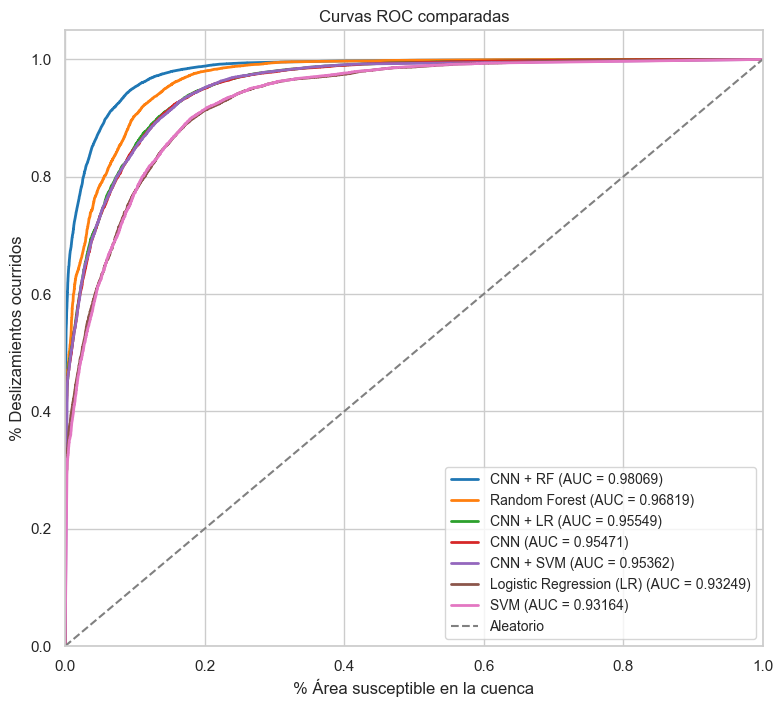

In [88]:
# =====================================================================
# LISTA DE MODELOS: (y_pred_proba, y_real, nombre)
# =====================================================================
modelos = [
    (y_pred_proba_LR,      y_test_MT, "Logistic Regression (LR)"),
    (y_pred_proba_SVM,     y_test_MT, "SVM"),
    (y_pred_proba_RF,      y_test_MT, "Random Forest"),
    (y_pred_proba_CNN,     y_test,    "CNN"),
    (y_probability_CNNLR,  test_y_np, "CNN + LR"),
    (y_probability_CNNSVM, test_y_np, "CNN + SVM"),
    (y_probability_CNNRF,  test_y_np, "CNN + RF"),
]

# Activar estilo visual Seaborn
sns.set_theme(style="whitegrid")

# ==========================================================
# CALCULAR FPR, TPR, AUC PARA CADA MODELO
# ==========================================================
resultados = []

for ypred, ytrue, nombre in modelos:
    fpr, tpr, _ = roc_curve(ytrue, ypred)
    auc_val = auc(fpr, tpr)
    resultados.append((auc_val, fpr, tpr, nombre))

# ==========================================================
# ORDENAR POR AUC (de mayor a menor)
# ==========================================================
resultados.sort(reverse=True, key=lambda x: x[0])

# Colores de Seaborn (tantos como modelos)
palette = sns.color_palette("tab10", len(resultados))

# ==========================================================
# GRAFICAR TODAS LAS ROC ORDENADAS
# ==========================================================
plt.figure(figsize=(9, 8))

for (auc_val, fpr, tpr, nombre), color in zip(resultados, palette):
    plt.plot(
        fpr, tpr,
        lw=2,
        color=color,
        label=f"{nombre} (AUC = {auc_val:.5f})"
    )

# Línea diagonal aleatoria
plt.plot([0, 1], [0, 1], "--", color="gray", lw=1.5, label="Aleatorio")

# ==========================================================
# ESTÉTICA GENERAL
# ==========================================================
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('% Área susceptible en la cuenca')
plt.ylabel('% Deslizamientos ocurridos')
plt.title('Curvas ROC comparadas')

plt.legend(loc="lower right", fontsize=10)

# Fuente
font = {'family': 'Times New Roman', 'weight': 'normal', 'size': 12}
plt.rc('font', **font)

# ==========================================================
# GUARDAR FIGURA
# ==========================================================
plt.savefig(
    "Curvas_ROC_Comparadas_AUC.png",
    dpi=300,
    bbox_inches='tight'
)

plt.show()


In [ ]:
del train_X, train_y, test_X, test_y, train_features, test_features
del y_pred_proba_LR
del y_test_MT
del y_pred_proba_SVM
del y_pred_proba_RF
del y_pred_proba_CNN
del y_test
del y_probability_CNNLR
del test_y_np
del y_probability_CNNSVM
del y_probability_CNNRF

gc.collect()

4037

### Generación de predicciones

Este bloque de código carga todos los archivos raster de la carpeta indicada y los convierte en tensores planos para su posterior procesamiento. Primero se leen los archivos `.tif` y se almacenan en una lista como arrays de NumPy. Luego, cada imagen se convierte en un tensor de PyTorch y se aplana para trabajar con vectores en lugar de matrices 2D. Después, se aplica una normalización por rango (min-max) ignorando valores especiales de no datos (como 15, -128 o -1), de modo que los píxeles válidos quedan escalados entre 0 y 1 mientras que los valores no válidos se conservan tal cual. Finalmente, todos los tensores normalizados se almacenan en la lista `Tensores_Normalizados_Com` y se liberan las variables temporales para ahorrar memoria. Esto prepara los datos completos para alimentar modelos o realizar predicciones sobre toda la extensión de la cuenca.


In [ ]:
ruta = r"D:/Edgar/01. Articulo regresión logistica/Insumos/Variables/Modelo Ordinal/completas"
archivostif =["PreProMen.tif",
              "Slope.tif",
              "Elevation.tif",
              "LitologyORD.tif", 
              "DisRivers.tif",
              "DisRoads.tif",
              "CLCORD.tif",
              "DisFalls.tif",
              "Curvature.tif",
              "TWI.tif" ]

ImagenesCompletas = []
TensoresCompletos = []

for archivo in archivostif:
    with rio.open(ruta+"/"+str(archivo)) as src:
        raster = src.read(1)
        ImagenesCompletas.append(raster)

for imagen in ImagenesCompletas:
    tensor = torch.tensor(imagen.astype(np.int16))
    TensoresCompletos.append(tensor)

del ImagenesCompletas, tensor, raster

TensoresCompletos = [tensor.flatten() for tensor in TensoresCompletos]

# Normalizar los tensores
Tensores_Normalizados_Com = []
for tensor in TensoresCompletos:
    if (tensor == 15).any():
        tensor_filtered = tensor[tensor != 15]
        tensor_normalized = (tensor_filtered.float() - tensor_filtered.min().item()) / (tensor_filtered.max().item() - tensor_filtered.min().item())
        tensor_normalized_full = torch.empty_like(tensor, dtype=torch.float)
        tensor_normalized_full[tensor != 15] = tensor_normalized
        tensor_normalized_full[tensor == 15] = tensor[tensor == 15].float()
    elif (tensor == -128).any():
        tensor_filtered = tensor[tensor != -128]
        tensor_normalized = (tensor_filtered.float() - tensor_filtered.min().item()) / (tensor_filtered.max().item() - tensor_filtered.min().item())
        tensor_normalized_full = torch.empty_like(tensor, dtype=torch.float)
        tensor_normalized_full[tensor != -128] = tensor_normalized
        tensor_normalized_full[tensor == -128] = tensor[tensor == -128].float()
    elif (tensor == -1).any():
        tensor_filtered = tensor[tensor != -1]
        tensor_normalized = (tensor_filtered.float() - tensor_filtered.min().item()) / (tensor_filtered.max().item() - tensor_filtered.min().item())
        tensor_normalized_full = torch.empty_like(tensor, dtype=torch.float)
        tensor_normalized_full[tensor != -1] = tensor_normalized
        tensor_normalized_full[tensor == -1] = tensor[tensor == -1].float()
    else:
        pass    

    Tensores_Normalizados_Com.append(tensor_normalized_full)

del TensoresCompletos, tensor_normalized_full, tensor_normalized, tensor_filtered

In [ ]:
gc.collect()

Este bloque construye una matriz de características (`X_com`) para todos los píxeles de la cuenca, pero usando un **memmap** para no saturar la memoria RAM. Primero se determina el número de variables (`num_variables`) y de registros totales (`num_records`) y se define un tamaño de lote (`batch_size`) para procesar los datos por partes. Luego se crea un archivo `X_com.dat` en disco como memmap para ir almacenando los datos en formato `float32`.

El bucle procesa los datos por lotes: para cada rango de píxeles, se arma un array temporal donde cada columna corresponde a una variable (raster) y cada fila a un píxel. Este batch se copia al memmap y luego se libera la memoria del batch temporal para mantener bajo el uso de RAM. Finalmente, se llama a `flush()` para asegurar que todos los cambios se escriban en disco. Esto permite manejar matrices enormes que no cabrían completamente en memoria.


In [ ]:
num_variables = len(Tensores_Normalizados_Com)
num_records = Tensores_Normalizados_Com[0].numel()  # total de registros
batch_size = 1_000_000  # ajusta según la RAM disponible

# Creamos un memmap en disco para almacenar el resultado
X_com_memmap = np.memmap('X_com.dat', dtype='float32', mode='w+', shape=(num_records, num_variables))

# Procesamos los tensores por lotes
start_idx = 0
for i in range(0, num_records, batch_size):
    end_idx = min(i + batch_size, num_records)
    batch_array = np.zeros((end_idx - i, num_variables), dtype=np.float32)
    
    for j, tensor in enumerate(Tensores_Normalizados_Com):
        tensor_flat = tensor.view(-1) if tensor.ndim > 1 else tensor
        batch_array[:, j] = tensor_flat[i:end_idx].numpy().astype(np.float32)
    
    X_com_memmap[start_idx:end_idx, :] = batch_array
    start_idx += batch_array.shape[0]

    # Liberamos memoria del batch temporal
    del batch_array
    gc.collect()

# Guardamos los cambios en disco
X_com_memmap.flush()

Este código inicializa `X_com` como un arreglo muy grande de NumPy usando `np.memmap`, lo que permite trabajar con datos que no caben completamente en la memoria RAM. Se define que hay 10 variables por registro y un total de más de 614 millones de registros. Los datos se almacenan en el archivo `X_com.dat` en el disco, y al usar `mode='r+'` se pueden leer y modificar directamente desde el disco. Esto permite acceder y manipular porciones del arreglo sin necesidad de cargar toda la matriz en memoria, haciendo eficiente el manejo de conjuntos de datos extremadamente grandes.


In [3]:
# Para usarlo como variable en Python:
num_variables = 10
num_records = 614871744    # ejemplo
X_com = np.memmap('X_com.dat', dtype='float32', mode='r+', shape=(num_records, num_variables))

Esta función `predict_in_batches_mm` está diseñada para generar predicciones de un modelo de manera eficiente cuando se trabaja con conjuntos de datos muy grandes que no caben completamente en memoria. Recibe un modelo que tenga el método `predict_proba`, un arreglo de entrada `X` (puede ser un `np.memmap`), la ruta de salida `output_path` donde se guardarán las predicciones, y un tamaño de lote `batch_size`.

El código crea un `memmap` en disco para almacenar las predicciones, de manera que no se consume memoria RAM excesiva. Luego recorre los datos en bloques del tamaño definido, calcula las probabilidades de la clase positiva (`[:,1]`) para cada bloque y las escribe directamente en el `memmap`. Al final, se asegura de liberar la memoria temporal y de guardar los cambios en disco con `flush()`. Así, se pueden procesar millones de registros de manera segura y eficiente sin que el equipo se quede sin memoria.


In [16]:
def predict_in_batches_mm(model, X, output_path, batch_size=50000):
    n = X.shape[0]
    mm = np.memmap(output_path, dtype='float64', mode='w+', shape=(n,))

    pos = 0
    for i in range(0, n, batch_size):
        batch = X[i:i+batch_size]
        preds = model.predict_proba(batch)[:,1]
        mm[pos:pos+len(preds)] = preds
        pos += len(preds)
        
    del preds

    mm.flush()
    return mm  

La función `save_file` permite guardar un arreglo de predicciones como un archivo TIFF, utilizando como referencia una imagen raster existente para mantener la misma geometría, resolución y sistema de coordenadas. Primero, define la ruta de la imagen original y la ruta de destino donde se guardará la predicción. Luego abre la imagen original con `rasterio` para extraer su perfil (información de tamaño, resolución, tipo de dato y transformaciones geográficas) y modifica el tipo de dato a `float32` para las predicciones. A continuación, redimensiona el arreglo de predicciones para que coincida exactamente con la forma (alto × ancho) de la imagen original, y finalmente crea un nuevo archivo TIFF en la ruta de destino, escribiendo el arreglo de predicciones usando el perfil de la imagen original para asegurar consistencia espacial.


In [8]:
def save_file(predicciones, nombre):
# Convertir el tensor a un arreglo numpy
    predicciones

# Especificar la ruta de la imagen raster original
    ruta = r"D:/Edgar/01. Articulo regresión logistica/Insumos/Variables/Modelo Ordinal/completas"
    ruta_imagen_original = ruta+"/"+"CLCORD.tif"
    
    # Especificar la ruta de destino para la imagen de predicciones
    ruta_predicciones = fr"D:/Edgar/01. Articulo Perceptroon-/Suscep_{nombre}.tif"

    # Abrir la imagen raster original para obtener las características
    with rio.open(ruta_imagen_original) as src:
        profile = src.profile  # Obtener el perfil de la imagen raster original
        profile['dtype'] = 'float32'  # Cambiar el dtype a float32

        # Leer la imagen raster original como un arreglo numpy
        imagen_original = src.read(1)

    # Redimensionar el arreglo numpy para que coincida con el tamaño de la imagen original
    predicciones = np.reshape(predicciones, imagen_original.shape)

    # Escribir el arreglo numpy como una imagen raster en formato TIFF
    with rio.open(ruta_predicciones, 'w', **profile) as dst:
        dst.write(predicciones, 1)

En este bloque se está generando un conjunto de predicciones usando el modelo de regresión logística (`modelLR`) sobre todo el conjunto de datos memmap `X_com` en lotes de 2 millones de registros para no saturar la memoria. La función `predict_in_batches_mm` devuelve un memmap en disco con las probabilidades de clase positiva para cada registro. La línea comentada `#save_file(prediccionesLR,"LR")` indica que se podría guardar este resultado como un archivo TIFF, pero en este caso no se ejecuta. Finalmente, `del prediccionesLR` libera la memoria asociada al objeto para mantener el uso de RAM bajo.


In [ ]:
prediccionesLR = predict_in_batches_mm(modelLR, X_com, "prediccionesLR",batch_size=2000000)
#save_file(prediccionesLR,"LR")
del prediccionesLR

Aquí se calculan las predicciones del modelo SVM (`ModelSVM1`) sobre el dataset completo `X_com` usando lotes de 2 millones de registros para no saturar la memoria. La función `predict_in_batches_mm` guarda las probabilidades de clase positiva en un memmap en disco llamado `"prediccionesSVM"`. La línea comentada `#save_file(prediccionesSVM,"SVM")` indica que se podría exportar estas predicciones como un archivo TIFF, pero no se ejecuta. Finalmente, `del prediccionesSVM` libera la memoria usada por el objeto de predicciones.


In [ ]:
prediccionesSVM = predict_in_batches_mm(ModelSVM1, X_com,  "prediccionesSVM",batch_size=2000000)
#save_file(prediccionesSVM,"SVM")
del prediccionesSVM

0

En este bloque se generan las predicciones del modelo Random Forest (`Modelrf`) sobre todo el dataset `X_com`, procesándolo en lotes de 2 millones de registros para manejar eficientemente la memoria. La función `predict_in_batches_mm` guarda las probabilidades de la clase positiva en un archivo memmap en disco llamado `"prediccionesRF"`. La línea comentada `#save_file(prediccionesRF,"RF")` indica que se podría exportar estas predicciones a un archivo TIFF, pero no se ejecuta. Finalmente, `del prediccionesRF` libera la memoria usada por las predicciones.


In [47]:
prediccionesRF = predict_in_batches_mm(Modelrf, X_com,  "prediccionesRF",batch_size=2000000)
#save_file(prediccionesRF,"RF")
del prediccionesRF

1219

In [50]:
gc.collect()

0

Este código convierte el arreglo de NumPy `X_com` a un tensor de tipo `float` (`X_tensor`), lo envuelve en un `TensorDataset` agregando una dimensión extra con `unsqueeze(1)` para obtener la forma `[N, 1, features]`, y finalmente crea un `DataLoader` que permite iterar sobre los datos en batches de 20 millones de muestras sin mezclarlos (`shuffle=False`) y sin usar procesos adicionales (`num_workers=0`), dejando los datos listos para alimentar un modelo de PyTorch.


In [ ]:
X_tensor = torch.from_numpy(X_com).float()        # [N, 10]
datasetx = TensorDataset(X_tensor.unsqueeze(1))   # [N, 1, features]
loader = DataLoader(datasetx, batch_size=20_000_000, shuffle=False, num_workers=0)

Este fragmento de código evalúa un modelo CNN (`ModelCNN`) sobre todos los datos del `DataLoader` `loader` y guarda las probabilidades de la clase 1 en un archivo de memoria mapeada (`probs_class.dat`). Primero se crea un `memmap` de NumPy para almacenar los resultados sin cargar todo en memoria. Luego, dentro de un bloque `torch.no_grad()` para desactivar el cálculo de gradientes, se itera sobre los batches del `DataLoader`, se obtienen los logits del modelo, se aplica manualmente la función softmax para calcular las probabilidades de cada clase, se extrae la probabilidad de la clase 1, y se guarda directamente en el `memmap` sin pasar por la CPU, incrementando un índice para mantener la posición correcta. Al final, se usa `flush()` para asegurar que todos los datos se escriban en disco.


In [ ]:
ModelCNN.eval()
N = len(loader.dataset)

# Crear memmap
probs_memmap = np.memmap("probs_class.dat", dtype="float32", mode="w+", shape=(N,) )

idx = 0

with torch.no_grad():
    for (batch,) in tqdm(loader, desc="Procesando", dynamic_ncols=True,leave=False):
        
        logits = ModelCNN(batch)       # [batch, 2]

        # Softmax manual (SIN CPU)
        exp_logits = torch.exp(logits)
        softmax_out = exp_logits / torch.sum(exp_logits, dim=1, keepdim=True)
        probs_class1 = softmax_out[:, 1]   # tensor

        # Guardar en memmap (SIN cpu() – usa numpy() directo)
        arr = probs_class1.numpy()         # NO fuerza nada
        b = arr.shape[0]

        probs_memmap[idx:idx+b] = arr
        idx += b

probs_memmap.flush()

save_file(probs_memmap,"CNN")


Este código extrae características de los datos utilizando un `feature_extractor` de PyTorch y las almacena en un archivo de memoria mapeada (`features_memmap.dat`). Primero se crea un `memmap` de NumPy con forma `(N, out_dim)` para guardar las features sin ocupar toda la memoria. Luego, en un bloque `torch.no_grad()`, se iteran los batches del `DataLoader`, se calculan las features del batch, se convierten directamente a un arreglo de NumPy y se escriben en el `memmap` en la posición correspondiente. Se lleva un conteo de registros procesados y se muestra un indicador de progreso, y al final se llama a `flush()` para asegurar que todos los datos se escriban en disco.



In [ ]:
# Crear memmap para almacenar las features
N = len(datasetx)
out_dim = 15   # dimensión de salida de feature_extractor
output_path = "features_memmap.dat"

features_mm = np.memmap(output_path, dtype='float32', mode='w+', shape=(N, out_dim))
feature_extractor.eval()

procesados = 0

with torch.no_grad():
    for batch_idx, (batch,) in enumerate(loader):

        # Extract features (CPU tensor)
        feats_tensor = feature_extractor(batch)      # [B, out_dim]

        # Convertir directamente a numpy (sin .cpu())
        feats_np = feats_tensor.numpy()

        B = feats_np.shape[0]

        # Guardar en memmap
        features_mm[procesados:procesados+B] = feats_np

        procesados += B

        # Indicador de progreso
        print(f"[{batch_idx+1}/{len(loader)}] "
              f"Procesados: {procesados}/{N} registros "
              f"({procesados/N*100:.2f}%)")

# Guardar en disco
features_mm.flush()


Este código abre el archivo memmap `"features_memmapx.dat"` que contiene las características extraídas previamente, interpretándolo como una matriz 2D de `float32` con `614.871.744` filas y `15` columnas. Al usar `mode='r'`, se accede solo en lectura, evitando cargar toda la matriz en memoria, lo que permite trabajar con datasets muy grandes de manera eficiente. Esto prepara los datos para ser usados directamente en modelos de machine learning o en análisis posterior sin saturar la RAM.


In [ ]:

cols = 15            # número de columnas reales
total_rows = 614_871_744  # número total de filas 

# Abrir todo el memmap como 2D
X_full = np.memmap("features_memmapx.dat", dtype='float32', mode='r', shape=(total_rows, cols))

Este bloque de código genera predicciones por lotes para todo el dataset de características almacenado en `X_full` usando el modelo `classifierCNNLR` (CNN seguida de regresión logística). La función `predict_in_batches_mm` procesa los datos en bloques de 2.000.000 de registros para no saturar la memoria, guardando las probabilidades de clase positiva en un archivo memmap llamado `"prediccionesCNNLR"`. Luego, el objeto `prediccionesCNNLR` se elimina de la memoria con `del` para liberar recursos. La línea comentada `#save_file(prediccionesCNNLR,"CNNLR")` indica que se podría guardar estas predicciones como un raster TIFF, pero actualmente está desactivada.


In [58]:
prediccionesCNNLR = predict_in_batches_mm(classifierCNNLR, X_full, "prediccionesCNNLR",batch_size=2000000)
#save_file(prediccionesCNNLR,"CNNLR")
del prediccionesCNNLR

En este bloque, se calculan las predicciones por lotes para todo el conjunto de características `X_full` usando el modelo `classifierCNNSVM` (CNN seguida de SVM). La función `predict_in_batches_mm` procesa los datos en bloques de 2.000.000 de registros para evitar problemas de memoria, guardando las probabilidades de clase positiva en un archivo memmap llamado `"prediccionesCNNSVM"`. Después de generar las predicciones, el objeto `prediccionesCNNSVM` se elimina de la memoria con `del` para liberar recursos. La línea comentada `#save_file(prediccionesCNNSVM,"CNNSVM")` sugiere que se podrían guardar estas predicciones como un archivo TIFF, pero actualmente está desactivada.


In [59]:
prediccionesCNNSVM = predict_in_batches_mm(classifierCNNSVM, X_full, "prediccionesCNNSVM",batch_size=2000000)
#save_file(prediccionesCNNSVM,"CNNSVM")
del prediccionesCNNSVM 

En este bloque, se generan las predicciones por lotes para todo el conjunto de características `X_full` usando el modelo `classifierCNNRF` (CNN seguida de Random Forest). La función `predict_in_batches_mm` procesa los datos en bloques de 2.000.000 de registros, escribiendo las probabilidades de clase positiva directamente en un archivo memmap llamado `"prediccionesCNNRF"`. Esto permite manejar un conjunto de datos muy grande sin sobrecargar la memoria. Tras completar la operación, el objeto `prediccionesCNNRF` se elimina con `del` para liberar RAM. La línea comentada `#save_file(prediccionesCNNRF,"CNNRF")` indica que existe la opción de guardar estas predicciones como un archivo TIFF, aunque actualmente no se ejecuta.


In [60]:
prediccionesCNNRF = predict_in_batches_mm(classifierCNNRF, X_full, "prediccionesCNNRF",batch_size=2000000)
#save_file(prediccionesCNNRF,"CNNRF")
del prediccionesCNNRF